In [51]:
from rdkit import Chem
import pandas as pd

# import module for chemical drawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# import packages for ml
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Try using 100K for demonstration
data = pd.read_csv(r'C:\Users\alex0\Documents\Python\Project\Repository\PV-Cell\PV-Cell\Database\HCEPD_100K.csv') 

### Sort out molecules that contain features: C-NH-C, N-S-N, Se 

In [3]:
def csse(x):
    """this function returns molecules that satisfy the requirement"""
    if (x.find('nsn') != -1) or (x.find('c[nH]c') != -1) or (x.find('Se') != -1):
        return True
    else:
        return False

In [4]:
data['structure'] = ""
data_csse = data[[csse(x) for x in data['SMILES_str']]]
print(len(data_csse),'molecules have at least one of the above features')
data_csse.head()

42019 molecules have at least one of the above features


,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str,structure
0,655365,C1C=CC=C1c1cc2[se]c3c4occc4c4nsnc4c3c2cn1,C18H9N3OSSe,394.3151,5.161953,0.867601,91.567575,-5.467601,2.022944,-3.444656,C1=CC=C(C1)c1cc2[se]c3c4occc4c4nsnc4c3c2cn1,
2,21847,C1C=c2ccc3c4c[nH]cc4c4c5[SiH2]C(=Cc5oc4c3c2=C1...,C24H17NOSi,363.4903,0.000000,0.000000,197.474780,-4.539526,1.462158,-3.077368,C1=CC=C(C1)C1=Cc2oc3c(c2[SiH2]1)c1c[nH]cc1c1cc...,
5,1310744,C1C=CC=C1c1cc2[se]c3c(c4nsnc4c4ccncc34)c2c2ccc...,C24H13N3SSe,454.4137,5.605135,0.951911,90.622776,-5.551911,2.029717,-3.522194,C1=CC=C(C1)c1cc2[se]c3c(c4nsnc4c4ccncc34)c2c2c...,
14,1638442,C1C=c2ccc3cnc4c5[SiH2]C(=Cc5c5nsnc5c4c3c2=C1)C...,C23H15N3SSi,393.5445,6.462512,0.602405,165.105179,-5.202405,1.603165,-3.599240,C1=CC=C(C1)C1=Cc2c([SiH2]1)c1ncc3ccc4=CCC=c4c3...,
16,2162747,C1C=CC=C1C1=Cc2c([SiH2]1)c1c3c[nH]cc3c3ccc4=C[...,C27H19NOSi2,429.6251,2.039158,0.140744,222.981280,-4.740744,1.361137,-3.379607,C1=CC=C(C1)C1=Cc2c([SiH2]1)c1c3c[nH]cc3c3ccc4=...,


Visualize the first 5 molecules from ``rdkit.Chem.Draw``

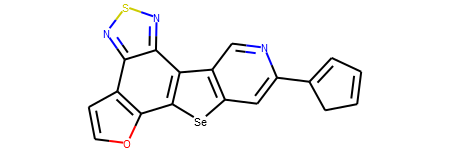

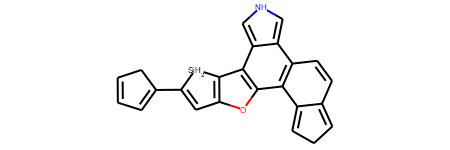

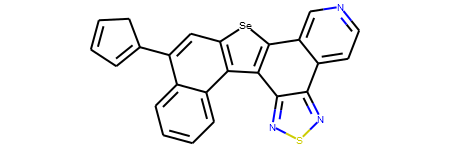

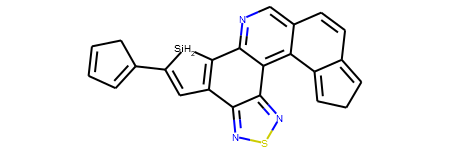

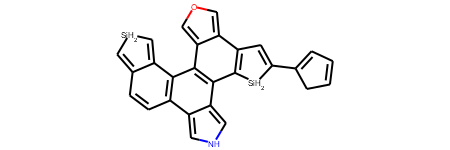

In [5]:
for i in range(5):
    data_csse['structure'].values[i] = Chem.MolFromSmiles(data_csse['SMILES_str'].values[i])
    display(data_csse['structure'].values[i])

### Score the weigh of each feature and predict its weight
Score 1 for the feature that exists in the molecule and 0 for none. Then find linear regression to predict how much contribution of each feature to the molecule's pce.
<br>
$y = a1 * x1 + a2 * x2 + a3 * x3 + e$

In [83]:
csse_df = pd.DataFrame({'SMILES_str':data_csse['SMILES_str'], 'pce':data_csse['pce']} )
nsn_value = []
chc_value = []
se_value = []
for mol in csse_df['SMILES_str']:
    if mol.find('nsn') != -1:
        nsn_value.append(1)
    else:
        nsn_value.append(0)
    if mol.find('c[nH]c') != -1:
        chc_value.append(1)
    else:
        chc_value.append(0)
    if mol.find('Se') != -1:
        se_value.append(1)
    else:
        se_value.append(0)
csse_df['nsn_value'] = nsn_value
csse_df['chc_value'] = chc_value
csse_df['se_value'] = se_value
csse_df.head()

,SMILES_str,pce,nsn_value,chc_value,se_value
0,C1C=CC=C1c1cc2[se]c3c4occc4c4nsnc4c3c2cn1,5.161953,1,0,0
2,C1C=c2ccc3c4c[nH]cc4c4c5[SiH2]C(=Cc5oc4c3c2=C1...,0.000000,0,1,0
5,C1C=CC=C1c1cc2[se]c3c(c4nsnc4c4ccncc34)c2c2ccc...,5.605135,1,0,0
14,C1C=c2ccc3cnc4c5[SiH2]C(=Cc5c5nsnc5c4c3c2=C1)C...,6.462512,1,0,0
16,C1C=CC=C1C1=Cc2c([SiH2]1)c1c3c[nH]cc3c3ccc4=C[...,2.039158,0,1,0


In [84]:
import pandas as pd
import numpy as np
import rdkit.Chem.EState as Estate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
# define a training dataset
xx = [csse_df['nsn_value'], csse_df['chc_value'], csse_df['se_value']]
X = np.array(xx).reshape(-1,3)
y = np.array(csse_df['pce'].values).reshape(-1,1)
seed =13544

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=seed)
# create the scaler from the training data only and keep it for later use
X_train_scaler = StandardScaler().fit(X_train)
# apply the scaler transform to the training data
X_train = X_train_scaler.transform(X_train)

C:\Users\alex0\Anaconda3\envs\pvc-env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\alex0\Anaconda3\envs\pvc-env\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [87]:
def simple_model():
    # assemble the structure
    model = Sequential()
    model.add(Dense(output_dim=9, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [88]:
estimator = KerasRegressor(build_fn=simple_model,
        epochs=1600, batch_size=2500, verbose=0)
history = estimator.fit(X_train, y_train, validation_split=0.33, epochs=150, 
        batch_size=1000, verbose=0)
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))

C:\Users\alex0\Anaconda3\envs\pvc-env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=3, kernel_initializer="normal", activation="relu", units=9)`
  after removing the cwd from sys.path.


final MSE for train is 6.63 and for validation is 6.70


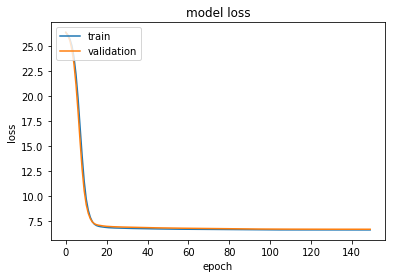

In [89]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

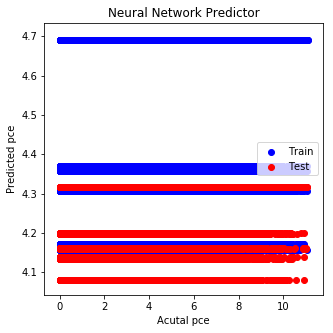

In [90]:
fig = plt.figure(figsize=(5,5))
plt.scatter(y_train,estimator.predict(X_train), label = 'Train', c='blue')
plt.scatter(y_test,estimator.predict(X_test), label = 'Test', c='r')
plt.title('Neural Network Predictor')
plt.xlabel('Acutal pce')
plt.ylabel('Predicted pce')
plt.legend(loc=5)
plt.show()